# Dynamic Pricing using Sales Forecasting.

## Business Problem

Avocado sales depend heavily on price.
We want to know:

"What should be the price of avocados next week (or the next 7 weeks) to maximize revenue?”

To answer that:

1. Forecast future sales volume.

2. Simulate different price points.

3. Choose the price that yields the highest predicted revenue.

## 1.Title & Problem Statement
### 🥑 Avocado Dynamic Pricing Using Machine-Learning Forecasts
Our objective is to predict future avocado sales volume and determine the price that maximizes expected revenue.


### Setup

This cell imports all the required libraries for data acquisition, preprocessing, visualization, time-series analysis, machine learning, and model evaluation. It also configures warnings for cleaner output.

Libraries used:

- pandas, numpy: Data manipulation and numerical computing

- pandas_datareader: Fetching financial and economic time-series data

- matplotlib, seaborn: Data visualization

- xgboost: Gradient boosting regression model

- shap: Model explainability and feature importance

- scikit-learn: Model evaluation metrics

- statsmodels: Time-series decomposition and autocorrelation analysis

- ipywidgets & IPython.display: Interactive controls and dynamic output

- joblib: Model persistence (save/load models)

- warnings: Suppress non-critical warnings

### Import the required libraries

In [ ]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import joblib
from xgboost import XGBRegressor
import shap
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from ipywidgets import Dropdown, fixed, interact
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Set color 
PRICE_COLOR  = "#FF7F0E"   # matplotlib orange
VOLUME_COLOR = "#1F77B4"   # matplotlib blue

#### Define the required functions 

Function to add inflation price to avocado prices and data loading with basic EDA

In [2]:
def add_inflation_adjusted_price(df, price_col='average_price', start=None, end=None):
    """
    Add CPI (inflation) data and inflation-adjusted price to avocado dataframe.
    
    Parameters:
    df : pd.DataFrame
        Must have a 'date' column of datetime type.
    price_col : str
        Name of the price column to adjust.
    start : datetime, optional
        Start date for CPI data fetch. Defaults to df['date'].min().
    end : datetime, optional
        End date for CPI data fetch. Defaults to df['date'].max().
        
    Returns:
    df : pd.DataFrame
        Original dataframe with added 'CPI', 'CPI_adj', and 'RealPrice' columns.
    """
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    # Ensure data is sorted by date
    df = df.sort_values('date')
    # Set start and end dates
    if start is None:
        start = df['date'].min()
    if end is None:
        end = df['date'].max()
    
    # Fetch CPI data from FRED
    cpi = web.DataReader("CPIAUCSL", "fred", start, end)
    
    # Backward-fill missing CPI
    cpi.fillna(method='bfill', inplace=True)
    # Merge CPI with avocado dataset using nearest previous date
    df = pd.merge_asof(
        df,
        cpi.rename(columns={'CPIAUCSL': 'CPI'}).sort_index(),
        left_on='date',
        right_index=True,
        direction='nearest'
    )
    
    # Normalize CPI to latest = 100
    df['CPI_adj'] = df['CPI'] / df['CPI'].iloc[-1] * 100

    # Calculate real price in latest dollars
    df['RealPrice'] = df[price_col] * (df['CPI'].iloc[-1] / df['CPI'])
    
    return df


def data_research(data, data_name='data'):
    """
    Perform a basic exploratory data analysis (EDA) on a DataFrame.

    This function prints and displays:
    - First few rows of the DataFrame
    - DataFrame info (column types, non-null counts)
    - Descriptive statistics (including for categorical columns)
    - Column names
    - Duplicate entries count
    - Missing values percentage (with a bar plot if any exist)
    - Unique values for object/string columns

    Parameters
    data : pd.DataFrame
        The DataFrame to examine.
    data_name : str, optional
        A name for the dataset (used in print statements), default is 'data'.

    Returns
    None
        The function prints information and displays plots but does not return anything.
    """
    # get basic stats
    print(f'Examining "{data_name}"')
    display(data.head())
    display(data.info())
    display(data.describe(include="all").T)
    display(data.columns)
    
    # find duplicates 
    duplicates = data.duplicated().sum()
    if duplicates > 0:
        print('There are no duplicated entries.')
    else:
        print(f'There are {duplicates} duplicates.')
        
    # find missing values
    data_missing = pd.DataFrame(round(data.isnull().sum() / data.shape[0] * 100, 2))
    if data_missing[0].sum() > 0:
        print(f'Missing values in the "{data_name}":')
        data_missing.plot(kind='bar')
    else:
        print(f'There are no missing values in "{data_name}".')
    
    # get unique values
    for i in data.columns:
        if data[i].dtype == 'object' or data[i].dtype == 'str':
            print(data[i].unique())
    

## Helper Functions

This cell defines helper functions for **time-series feature engineering** used in sales forecasting.

The engineered features are designed to capture:

- **Temporal dependencies** (lagged effects)
- **Momentum and trend stability** (rolling statistics)
- **Seasonality effects** (year-over-year differences)
- **Price–volume relationships** (interaction terms)

All features are computed **within each `(geography, type)` group** to avoid information leakage across regions or product types.

---

### Overview of Functions

#### `add_lagged_features()`

Creates lagged values and robust rolling medians for both **sales volume** and **price**.

These features enable the model to learn **short- and medium-term temporal dependencies** while reducing sensitivity to outliers.

---

#### `add_new_features()`

Adds:
- **Volatility measures** (rolling standard deviation)
- **Year-over-year changes**
- **Price–volume interaction terms**

These features help capture **demand sensitivity**, stability, and seasonal dynamics.

---

#### `plot_predictions()`

Function to visualize **actual vs. predicted sales over time**, aggregated by date.

This function supports model evaluation and qualitative assessment of forecast performance.

---

All engineered features serve as inputs to downstream forecasting models and are constructed **using only past information** to maintain **causal consistency** and prevent look-ahead bias.


In [3]:
def add_lagged_features(
    df: pd.DataFrame,
    group_cols=('geography', 'type'),
    target_col='total_volume',
    price_col='RealPrice',
    lags=(1, 2, 3, 4),
    roll_windows=(3, 4, 8),
):
    """
    Adds lagged and rolling features for sales and price.
    Works per group (e.g., per region and type).
    
    Parameters
    df : pd.DataFrame
        Input DataFrame sorted by date.
    group_cols : list or tuple
        Columns to group by (e.g., region, type).
    target_col : str
        Target variable column name (e.g., 'total_volume').
    price_col : str
        Price column name (e.g., 'average_price').
    lags : tuple
        Lag periods (in weeks, if weekly data).
    roll_windows : tuple
        Window sizes for rolling means/stds.
        
    Returns
    pd.DataFrame
        DataFrame with new lag and rolling features.New columns include:
        - `{target_col}_lag{L}`
        - `{price_col}_lag{L}`
        - `{target_col}_rollmedian{w}`
        - `{price_col}_rollmedian{w}`
    """

    # Ensure sorted within groups
    df = df.sort_values(list(group_cols) + ['date']).copy()
    g = df.groupby(list(group_cols), group_keys=False)

    # --- Add lag features for sales and price ---
    for L in lags:
        df[f"{target_col}_lag{L}"] = g[target_col].shift(L)
        df[f"{price_col}_lag{L}"] = g[price_col].shift(L)

    # --- Add robust rolling features ---
    for w in roll_windows:
        # Median
        df[f"{target_col}_rollmedian{w}"] = g[target_col].shift(1).rolling(w).median()
        df[f"{price_col}_rollmedian{w}"]  = g[price_col].shift(1).rolling(w).median()

    return df


def add_new_features(df):
    """
    Add additional engineered features to the DataFrame.

    Computes rolling standard deviation, year-over-year differences, and interaction 
    features for sales and price data grouped by 'geography' and 'type'.

    Parameters
    df : pd.DataFrame
        Input DataFrame containing at least:
        - 'geography', 'type', 'total_volume', 'RealPrice'

    Returns
    pd.DataFrame
        DataFrame with the following new features:
        - Rolling standard deviations for different windows
        - Year-over-year differences for sales and price
        - Interaction features:
          - price_volume_interaction = RealPrice * total_volume
    """
    g = df.groupby(['geography', 'type'], group_keys=False)

    # --- Volatility (rolling std only) ---
    for w in [3, 4, 8]:
        df[f'total_volume_rollstd{w}'] = g['total_volume'].shift(1).rolling(w).std()
        df[f'RealPrice_rollstd{w}'] = g['RealPrice'].shift(1).rolling(w).std()

    # --- Year-over-Year Differences ---
    df['total_volume_yoy_diff'] = g['total_volume'].diff(52)
    df['RealPrice_yoy_diff'] = g['RealPrice'].diff(52)

    # --- Interaction Features ---
    df['price_volume_interaction'] = df['RealPrice'] * df['total_volume']
    return df


def plot_predictions(df, target_col, pred_col, horizon):
    """
    Plot actual vs. predicted values over time.
    """
    df = df.sort_values('date')
    df = df.groupby('date', as_index=False)[[target_col, pred_col]].mean()

    fig, ax = plt.subplots(figsize=(12, 5))

    ax.plot(df['date'], df[target_col], label='Actual', marker='o', color=VOLUME_COLOR)
    ax.plot(df['date'], df[pred_col], label='Predicted', marker='x', color=PRICE_COLOR)

    ax.set_title(f'Sales Forecast: {horizon} week')
    ax.set_xlabel('Date')
    ax.set_ylabel("Predicted Volume")

    # ---------- FIX X-AXIS ----------
    ax.xaxis.set_major_locator(mdates.MonthLocator())              
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')        

    ax.grid(True, alpha=0.3)
    ax.legend()

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()
    plt.close()
    

## 2. Dataset Overview & EDA

This section describes the source, granularity, and structure of the avocado dataset.
- Frequency: weekly
- Features: price, total volume, type, region
- Target: weekly total volume
- Real-price adjustment

Visualize correlations, distributions, and trends to eliminate redundant features and understand key drivers.



In [4]:
# Load the avocado dataset
df = pd.read_csv(r".\data\avocado-updated-2020.csv")
# Convert Date to datetime format
df['date'] = pd.to_datetime(df['date'])
df = add_inflation_adjusted_price(df)
# Sort by date
df = df.sort_values('date')
data_research(df, 'avocado')


Examining "avocado"


,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography,CPI,CPI_adj,RealPrice
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,235.342,90.200107,1.352548
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany,235.342,90.200107,1.984477
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta,235.342,90.200107,1.108646
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta,235.342,90.200107,1.951217
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington,235.342,90.200107,1.197338


<class 'pandas.core.frame.DataFrame'>
Index: 33045 entries, 0 to 33044
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           33045 non-null  datetime64[ns]
 1   average_price  33045 non-null  float64       
 2   total_volume   33045 non-null  float64       
 3   4046           33045 non-null  float64       
 4   4225           33045 non-null  float64       
 5   4770           33045 non-null  float64       
 6   total_bags     33045 non-null  float64       
 7   small_bags     33045 non-null  float64       
 8   large_bags     33045 non-null  float64       
 9   xlarge_bags    33045 non-null  float64       
 10  type           33045 non-null  object        
 11  year           33045 non-null  int64         
 12  geography      33045 non-null  object        
 13  CPI            33045 non-null  float64       
 14  CPI_adj        33045 non-null  float64       
 15  RealPrice      33045 non

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,33045,NaN,NaN,NaN,2017-12-12 06:49:37.394461952,2015-01-04 00:00:00,2016-06-19 00:00:00,2017-12-10 00:00:00,2019-06-16 00:00:00,2020-11-29 00:00:00,NaN
average_price,33045.0,NaN,NaN,NaN,1.379941,0.44,1.1,1.35,1.62,3.25,0.378972
total_volume,33045.0,NaN,NaN,NaN,968399.676291,84.56,15118.95,129116.98,505828.46,63716144.15,3934532.637117
4046,33045.0,NaN,NaN,NaN,302391.405241,0.0,767.31,10994.77,119021.85,22743616.17,1301025.920091
4225,33045.0,NaN,NaN,NaN,279769.300885,0.0,2712.47,23436.0,135238.94,20470572.61,1151052.266745
4770,33045.0,NaN,NaN,NaN,21482.550773,0.0,0.0,178.09,5096.53,2546439.11,100160.701957
total_bags,33045.0,NaN,NaN,NaN,364673.476366,0.0,9121.86,53222.24,174431.43,31689188.6,1564003.996535
small_bags,33045.0,NaN,NaN,NaN,250198.016346,0.0,6478.63,36876.99,120662.4,20550406.59,1037734.175672
large_bags,33045.0,NaN,NaN,NaN,106732.875171,0.0,466.29,6375.86,40417.23,13327600.76,516722.594117
xlarge_bags,33045.0,NaN,NaN,NaN,7742.584637,0.0,0.0,0.0,804.44,1403184.04,48198.030842


Index(['date', 'average_price', 'total_volume', '4046', '4225', '4770',
       'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'type', 'year',
       'geography', 'CPI', 'CPI_adj', 'RealPrice'],
      dtype='object')

There are 0 duplicates.
There are no missing values in "avocado".
['conventional' 'organic']
['Albany' 'Atlanta' 'Baltimore/Washington' 'Boise' 'Boston'
 'Buffalo/Rochester' 'California' 'Denver' 'Charlotte' 'Chicago'
 'Cincinnati/Dayton' 'Columbus' 'Dallas/Ft. Worth' 'Nashville' 'Detroit'
 'Midsouth' 'Indianapolis' 'Grand Rapids' 'Great Lakes'
 'Harrisburg/Scranton' 'Hartford/Springfield' 'Houston' 'Los Angeles'
 'Jacksonville' 'Las Vegas' 'Louisville' 'Miami/Ft. Lauderdale'
 'Sacramento' 'Spokane' 'Roanoke' 'New York' 'Northeast'
 'Northern New England' 'Orlando' 'Philadelphia' 'Phoenix/Tucson'
 'Pittsburgh' 'Plains' 'Portland' 'Raleigh/Greensboro' 'Richmond/Norfolk'
 'New Orleans/Mobile' 'San Diego' 'San Francisco' 'Seattle'
 'South Carolina' 'South Central' 'Southeast' 'St. Louis'
 'West Tex/New Mexico' 'Syracuse' 'Tampa' 'Total U.S.' 'West']


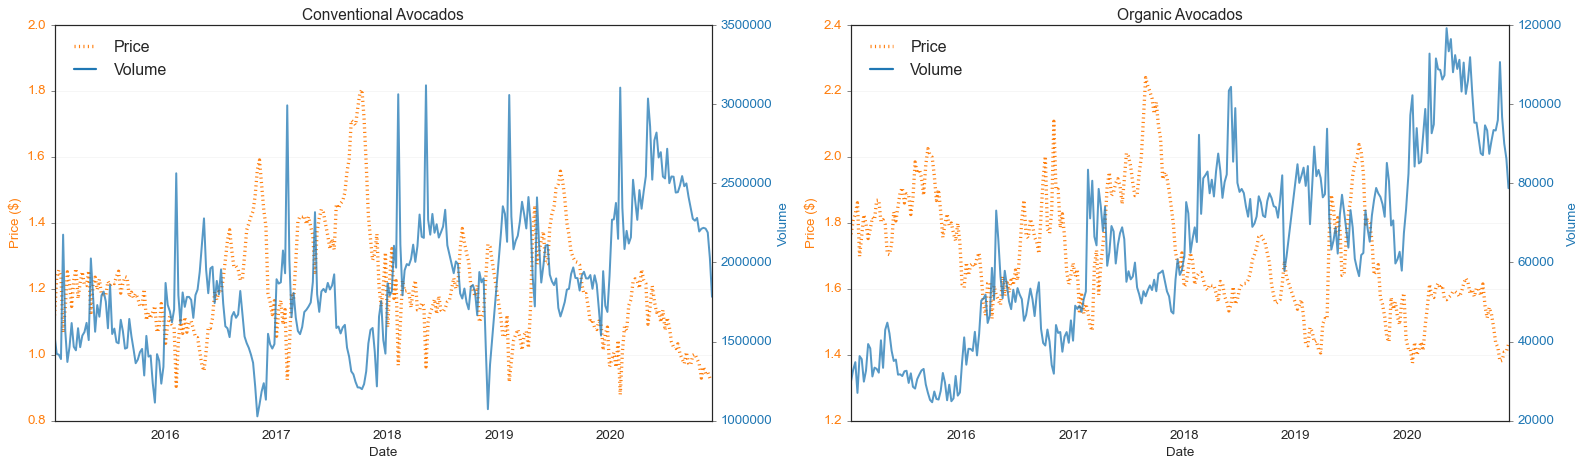

In [5]:
# ----------------------------
# Styling
# ----------------------------
plt.style.use("classic")
sns.set_style("white")

# ----------------------------
# Prepare data
# ----------------------------
df_conv = df[df["type"] == "conventional"].copy()
df_org  = df[df["type"] == "organic"].copy()

# ----------------------------
# Figure
# ----------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# ============================
# Conventional Avocados
# ============================
ax1 = axes[0]

sns.lineplot(
    data=df_conv,
    x="date",
    y="RealPrice",
    ax=ax1,
    color=PRICE_COLOR,
    linestyle=":",
    linewidth=3,
    ci=None
)

ax1.set_title("Conventional Avocados", fontsize=14)
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($)", color=PRICE_COLOR)
ax1.tick_params(axis="y", labelcolor=PRICE_COLOR)
ax1.grid(True, axis="y", alpha=0.3)

# Volume axis
ax2 = ax1.twinx()
sns.lineplot(
    data=df_conv,
    x="date",
    y="total_volume",
    ax=ax2,
    color=VOLUME_COLOR,
    linewidth=1.8,
    alpha=0.75,
    ci=None
)
ax2.set_ylabel("Volume", color=VOLUME_COLOR)
ax2.tick_params(axis="y", labelcolor=VOLUME_COLOR)

# Date formatting
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Legend
legend_lines = [
    Line2D([0], [0], color=PRICE_COLOR, lw=3, linestyle=":", label="Price"),
    Line2D([0], [0], color=VOLUME_COLOR, lw=2, label="Volume")
]
ax1.legend(handles=legend_lines, loc="upper left", frameon=False)

# ============================
# Organic Avocados
# ============================
ax3 = axes[1]

sns.lineplot(
    data=df_org,
    x="date",
    y="RealPrice",
    ax=ax3,
    color=PRICE_COLOR,
    linestyle=":",
    linewidth=3,
    ci=None
)

ax3.set_title("Organic Avocados", fontsize=14)
ax3.set_xlabel("Date")
ax3.set_ylabel("Price ($)", color=PRICE_COLOR)
ax3.tick_params(axis="y", labelcolor=PRICE_COLOR)
ax3.grid(True, axis="y", alpha=0.3)

# Volume axis
ax4 = ax3.twinx()
sns.lineplot(
    data=df_org,
    x="date",
    y="total_volume",
    ax=ax4,
    color=VOLUME_COLOR,
    linewidth=1.8,
    alpha=0.75,
    ci=None
)
ax4.set_ylabel("Volume", color=VOLUME_COLOR)
ax4.tick_params(axis="y", labelcolor=VOLUME_COLOR)

# Date formatting
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

# Legend
ax3.legend(handles=legend_lines, loc="upper left", frameon=False)

# ----------------------------
# Layout
# ----------------------------
plt.subplots_adjust(wspace=0.25)
plt.tight_layout()
plt.show()


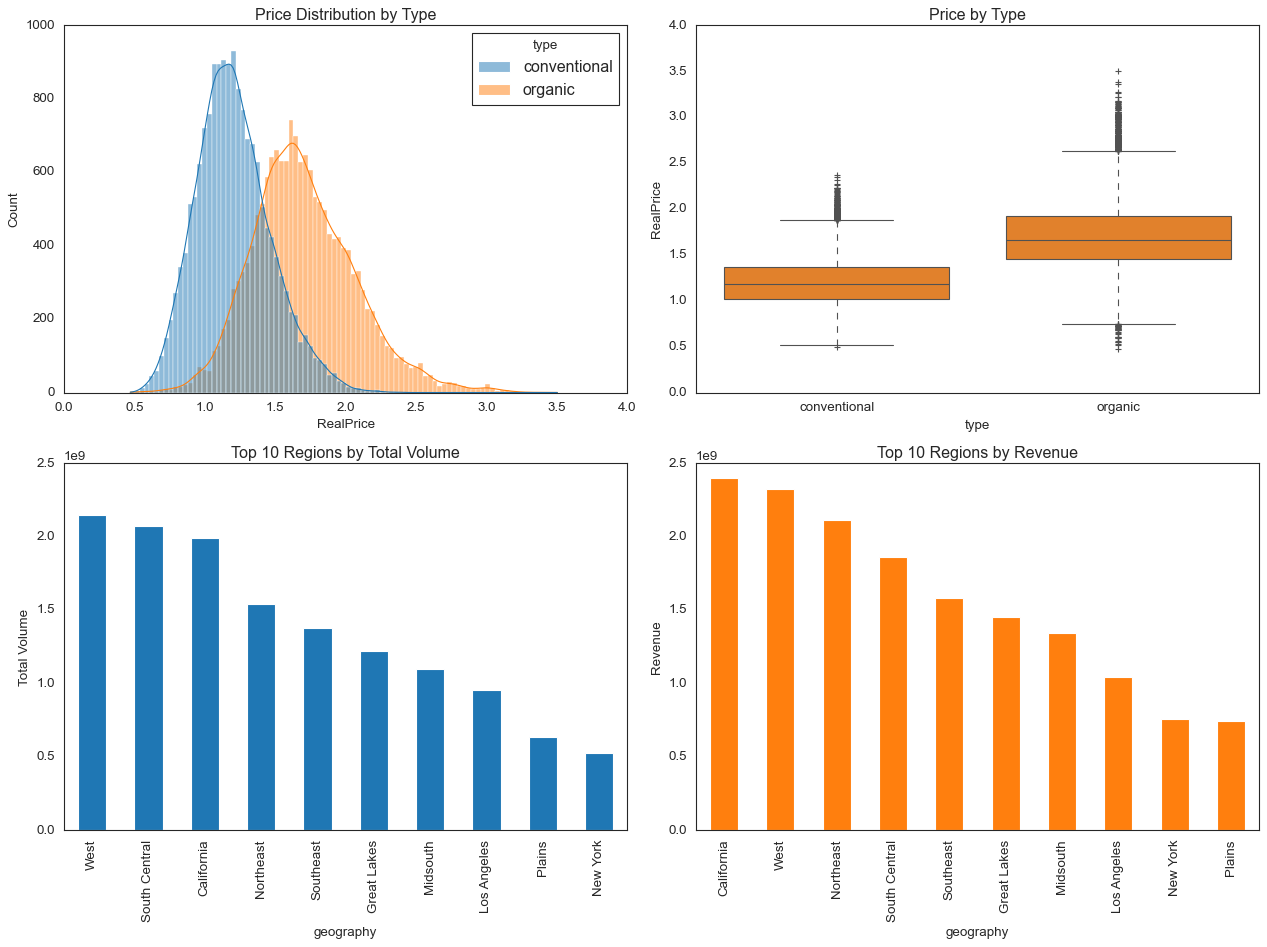

In [6]:
# Prepare aggregated data
top_regions = df.groupby('geography')['total_volume'].sum().sort_values(ascending=False).iloc[1:11]
top_revenue_region = (
    df.assign(revenue=df['RealPrice'] * df['total_volume'])
      .groupby('geography')['revenue']
      .sum()
      .sort_values(ascending=False)
      .iloc[1:11]
)
# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# Histogram 
sns.histplot(
    data=df,
    x="RealPrice",
    hue="type",
    kde=True,
    ax=axes[0, 0],
    palette=[VOLUME_COLOR, PRICE_COLOR]
)
axes[0, 0].set_title("Price Distribution by Type")

# Boxplot 
sns.boxplot(
    data=df,
    x="type",
    y="RealPrice",
    ax=axes[0, 1],
    color=PRICE_COLOR
)
axes[0, 1].set_title("Price by Type")

# Top 10 Regions by Total Volume 
top_regions.plot(
    kind='bar',
    color=VOLUME_COLOR,
    ax=axes[1, 0]
)
axes[1, 0].set_title("Top 10 Regions by Total Volume")
axes[1, 0].set_ylabel("Total Volume")

# Top 10 Regions by Average Price 
top_revenue_region.plot(
    kind='bar',
    color=PRICE_COLOR,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Top 10 Regions by Revenue")
axes[1, 1].set_ylabel("Revenue")

# Adjust spacing
plt.tight_layout()
plt.show()

## Time-Series Analysis
### Trend and Seasonality in Avocado Volume

Total avocado sales volumes are aggregated across all markets by date.  
A classical seasonal decomposition (seasonal_decompose) is applied to the weekly time series to separate the long-term trend, the annual seasonal pattern (52-week cycle), and the irregular residual component.

In [7]:
region_options = ['All'] + sorted(df['geography'].dropna().unique().tolist())

def plot_seasonality_by_type(geography):
    """
    Plot seasonal decomposition of weekly total sales volume by avocado type.

    This function performs an additive seasonal decomposition of weekly
    `total_volume` for each avocado type (e.g., conventional, organic) within
    the selected geography. For each type, it visualizes the observed series,
    long-term trend, seasonal component, and residuals in vertically stacked
    subplots.

    The decomposition helps identify long-term trends, yearly seasonality
    (52-week cycle), and irregular fluctuations in avocado demand across
    different product types and regions.

    Parameters
    geography : str
        Geographic region to filter the data.
        - If 'All', data from all geographies are included.
        - Otherwise, only data matching the selected geography are used.

    Returns
    None
        Displays seasonal decomposition plots for each avocado type. No values
        are returned.
    """
    clear_output(wait=True)

    dff = df.copy()

    if geography != 'All':
        dff = dff[dff['geography'] == geography]

    if dff.empty:
        print("No data available for this selection")
        return

    types = sorted(dff['type'].dropna().unique())
    n_types = len(types)

    fig, axes = plt.subplots(
        4, n_types,
        figsize=(7 * n_types, 10),
        sharex='col'
    )

    if n_types == 1:
        axes = axes.reshape(4, 1)

    fig.suptitle(
        f"Seasonality Decomposition by Type\nGeography: {geography}",
        fontsize=14
    )

    for col, prod_type in enumerate(types):

        dff_type = dff[dff['type'] == prod_type]

        df_vol = (
            dff_type.groupby('date')['total_volume']
                    .sum()
                    .sort_index()
        )

        if df_vol.empty:
            continue

        result = seasonal_decompose(
            df_vol,
            model='additive',
            period=52
        )

        axes[0, col].set_title(f"Type: {prod_type}", fontsize=12)

        axes[0, col].plot(result.observed, color='steelblue', linewidth=1.5)
        axes[1, col].plot(result.trend, color='darkgreen', linewidth=2)
        axes[2, col].plot(result.seasonal, color='darkorange', linewidth=1.5)
        axes[2, col].axhline(0, color='black', linestyle='--', linewidth=0.8)

        axes[3, col].scatter(
            result.resid.index,
            result.resid,
            s=15,
            color='purple',
            alpha=0.6
        )
        axes[3, col].axhline(0, color='black', linestyle='--', linewidth=0.8)

        for row in range(4):
            ax = axes[row, col]
            ax.grid(alpha=0.3)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

    row_labels = ["Observed", "Trend", "Seasonal", "Residual"]
    for row, label in enumerate(row_labels):
        axes[row, 0].set_ylabel(label)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
interact(
    plot_seasonality_by_type,
    geography=Dropdown(
        options=region_options,
        value='All',
        description='Geography:'
    )
)

interactive(children=(Dropdown(description='Geography:', options=('All', 'Albany', 'Atlanta', 'Baltimore/Washi…

<function __main__.plot_seasonality_by_type(geography)>

### Autocorrelation 

Autocorrelation is examined to assess temporal dependence and guide model selection.   
The ACF shows rapid decay and weak correlations across lags, suggesting limited linear dependence and motivating the use of feature-based machine learning models rather than purely autoregressive approaches.


In [8]:
def plot_acf_by_type(geography):
    """
    Plot autocorrelation functions (ACF) of weekly total sales volume by avocado type.

    This function filters the global dataset by the selected geography and computes
    the autocorrelation of weekly `total_volume` separately for each avocado type
    (e.g., conventional, organic). Each type is displayed in its own subplot for
    side-by-side comparison.

    The plot is intended to help identify temporal dependencies, seasonality,
    and lag effects in demand patterns across different avocado types and regions.

    Parameters
    geography : str
        Geographic region to filter the data.
        - If 'All', data from all geographies are included.
        - Otherwise, only data matching the selected geography are used.

    Returns
    None
    """
    clear_output(wait=True)
    # --- Filter data ---
    dff = df.copy()
    if geography != 'All':
        dff = dff[dff['geography'] == geography]

    if dff.empty:
        print("No data for selected geography")
        return

    types = sorted(dff['type'].dropna().unique())
    n_types = len(types)

    # --- Style ---
    sns.set_style("white")
    plt.rcParams.update({
        "font.size": 14,
        "axes.edgecolor": "black",
        "axes.linewidth": 1.0,
        "figure.dpi": 150,
    })

    fig, axes = plt.subplots(
        1, n_types,
        figsize=(6 * n_types, 5),
        sharey=True
    )

    if n_types == 1:
        axes = [axes]

    for col, prod_type in enumerate(types):
        ax = axes[col]
        dff_type = dff[dff['type'] == prod_type]

        if dff_type.empty:
            continue

        plot_acf(
            dff_type['total_volume'],
            lags=15,
            zero=False,
            alpha=None,
            ax=ax,
            marker='o'
        )

        # --- Customize stems ---
        for line in ax.lines:
            line.set_color("black")
            line.set_linewidth(1.2)

        ax.plot(
            ax.lines[0].get_xdata(),
            ax.lines[0].get_ydata(),
            'o',
            markersize=4,
            color="navy"
        )

        ax.axhline(0, color="black", linewidth=1)
        sns.despine(ax=ax, trim=True)

        ax.set_title(f"Type: {prod_type}", fontsize=14)
        ax.set_xlabel("Lag (weeks)")
        ax.set_ylabel("Autocorrelation" if col == 0 else "")

    fig.suptitle(
        f"Autocorrelation of Weekly Total Volume\nGeography: {geography}",
        fontsize=16,
        y=1.05
    )

    plt.tight_layout()
    plt.show()
    
    
interact(
    plot_acf_by_type,
    geography=Dropdown(
        options=region_options,
        value='All',
        description='Geography:'
    )
)


interactive(children=(Dropdown(description='Geography:', options=('All', 'Albany', 'Atlanta', 'Baltimore/Washi…

<function __main__.plot_acf_by_type(geography)>

## 3. Feature Engineering

Insights from the analysis directly inform the feature engineering strategy used for the XGBoost model:

- Trend information is captured through lagged values of total_volume and rolling statistics (median and standard deviation).

- Seasonality is modeled using calendar features (week, month, quarter) rather than an explicit seasonal term, allowing XGBoost to learn nonlinear seasonal effects.

- Temporal dependence is addressed using multiple lag features (lag1–lag4) and rolling windows.

- Price–volume dynamics are incorporated through real price variables, lagged prices, year-over-year differences, and interaction terms.

- Multi-horizon forecasting is enabled through horizon-specific features (t_plus_n variables and horizon).

Together, these features allow the model to learn trend, seasonality, and short-term dynamics in a flexible, non-parametric manner without requiring explicit time-series assumptions.

In [9]:
df_lagged = add_lagged_features(df)
df_lagged = add_new_features(df_lagged)

#### Add Time-Based 
Convert date to month, week, quarter based time features

In [10]:
df_lagged['month'] = df_lagged['date'].dt.month
df_lagged['week'] = df_lagged['date'].dt.isocalendar().week.astype(int)
df_lagged['quarter'] = df_lagged['date'].dt.quarter

#### Drop columns
Drop columns small_bags, large_bags, xlarge_bags, CPI, average_price

In [11]:
df_lagged = df_lagged.drop(columns=["average_price", "small_bags", "large_bags", "xlarge_bags", "CPI", "total_bags", "4046", "4225", "4770"])

## 4. Forecasting Setup (Direct Multi-Step Forecasting)

Define the forecasting horizons (week 1 to week 7) and process the target variable

Multi-horizon forecasting is used (1–7 weeks ahead). Each horizon gets:
- A shifted target
- A shifted future price
- Seasonal context


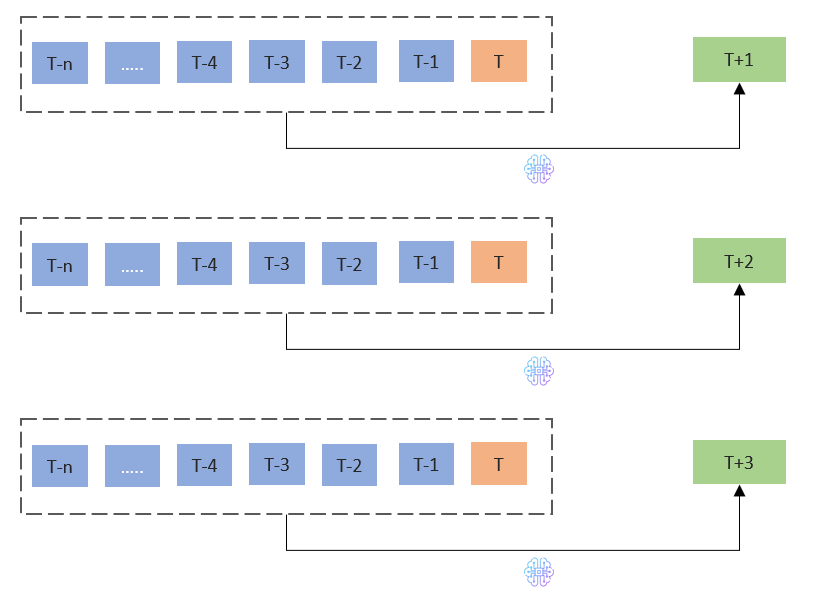

In [12]:
def stack_horizons(df, target_col='total_volume', seasonal_cols=None, horizons=(1,2,3,4,5)):
    """
    Stack future horizons for a time series forecasting task.

    Converts a wide time series DataFrame into a long-format DataFrame where each row 
    corresponds to a specific forecast horizon. Adds shifted target, price, and optional 
    seasonal features for each horizon.

    Parameters
    df : pd.DataFrame
        Input DataFrame containing at least 'geography', 'type', 'date', target, and price columns.
    target_col : str, default 'total_volume'
        Name of the target column to forecast.
    seasonal_cols : list of str, optional
        List of additional seasonal columns to shift for each horizon.
    horizons : tuple of int, default (1, 2, 3, 4, 5)
        Forecast horizons (number of steps ahead) to create.

    Returns
    pd.DataFrame
        Long-format DataFrame with:
        - `{target_col}_t_plus_n` : Target shifted by n steps ahead
        - `RealPrice_t_plus_n` : Price shifted by n steps ahead
        - `{seasonal_col}_t_plus_n` : Optional seasonal features shifted by n steps ahead
        - `horizon` : Horizon identifier (n)
        Rows with NaNs due to shifting are dropped.
    """
    df_list = []
    sort_cols = ['geography', 'type', 'date']
    price_column = "RealPrice"
    df = df.sort_values(sort_cols)
    for n in horizons:
        df_n = df.copy()
        df_n[f'{target_col}_t_plus_n'] = df_n.groupby(['geography', 'type'])[target_col].shift(-n)
        df_n[f'{price_column}_t_plus_n'] = df_n.groupby(['geography', 'type'])[price_column].shift(-n)
        if seasonal_cols:
            for col in seasonal_cols:
                df_n[f'{col}_t_plus_n'] = df_n.groupby(['geography', 'type'])[col].shift(-n)
        df_n['horizon'] = n
        df_list.append(df_n)
    
    df_stacked = pd.concat(df_list, axis=0).dropna()
    return df_stacked

horizons = range(1,8)  # forecast next 7 weeks
seasonal = ['week', 'month', 'quarter']
df_model = stack_horizons(df_lagged, seasonal_cols=seasonal, horizons=horizons)
df_model['geography'] = df_model['geography'].astype('category')
df_model['type'] = df_model['type'].astype('category')

## 5. Model Training
Train gradient-boosted regression model (xgboost).
Rationale:
- Handles nonlinear interactions
- Robust to correlated features
- Works well for engineered time-series features

The data is split into training (2015–2019) and testing (2020) periods to evaluate out-of-sample forecast performance.

In [13]:
# -----------------------------
#  Train-test split (time aware)
# -----------------------------

df_train = df_model[df_model['date'] < '2020-01-01'].sort_values('date')
df_test  = df_model[df_model['date'] >= '2020-01-01'].sort_values('date')

# -----------------------------
# Prepare features and target
# -----------------------------
exclude_cols = ['total_volume_t_plus_n']
features = [c for c in df_model.columns if c not in exclude_cols + ['date']]

X_train, y_train = df_train[features], df_train['total_volume_t_plus_n']
X_test, y_test = df_test[features], df_test['total_volume_t_plus_n']

model_all = XGBRegressor(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=4,
    min_child_weight=15,
    colsample_bytree=0.8,
    reg_lambda=20.0,
    reg_alpha=10,
    enable_categorical=True,
    random_state=42,
    gamma = 10,
)

model_all.fit(
    X_train, y_train
)
# save the model
joblib.dump(model_all, "xgb_all.joblib")

['xgb_all.joblib']

## 6. Model Evaluation

To assess the performance of the XGBoost model, we evaluate prediction errors separately for each forecast horizon.
Evaluating by horizon helps us understand how model accuracy degrades as we predict further into the future.

We report the following metrics:

- RMSE (Root Mean Squared Error):
Penalizes large errors more heavily and is useful for understanding overall prediction accuracy.

- RMAE (Relative Mean Absolute Error):
Scales the absolute error relative to the actual values, making it easier to compare performance across horizons.

- RMAPE (Relative Mean Absolute Percentage Error):
Measures the average percentage error, providing an intuitive sense of forecast deviation.

- R² (Coefficient of Determination):
Indicates how well the model explains the variance in the target variable for each horizon.

Together these metrics provide a balanced view of error magnitude, relative performance, and explanatory power of the XGBoost model across forecast horizons.

In [14]:
def evaluate_and_plot_on_test(
    model, 
    df_test, 
    horizons=range(1, 8), 
    target_col='total_volume_t_plus_n', 
    pred_col='y_pred', 
    plot=True
):
    """
    Evaluate a predictive model on a test set across multiple forecast horizons and optionally plot results.

    Computes standard regression metrics (R2, RMSE, MAE, MAPE) for each horizon and optionally 
    provides an interactive plot to visualize actual vs. predicted values.

    Parameters
    model : object
        Trained model with a `predict` method compatible with input features from df_test.
    df_test : pd.DataFrame
        Test dataset containing feature columns, `target_col`, and a `horizon` column.
    horizons : iterable of int, default range(1, 8)
        Forecast horizons to evaluate.
    target_col : str, default 'total_volume_t_plus_n'
        Name of the target column for evaluation.
    pred_col : str, default 'y_pred'
        Column name to store predicted values.
    plot : bool, default True
        If True, enables interactive plotting with a dropdown to select horizon.

    Returns
    results_df : pd.DataFrame
        DataFrame summarizing evaluation metrics per horizon, including an average row.
    df_test : pd.DataFrame
        Test DataFrame updated with predictions in `pred_col`.
    """

    # Ensure prediction column exists
    if pred_col not in df_test.columns:
        df_test[pred_col] = np.nan

    results = []

    # Run evaluation (NO plotting inside loop)
    for n in horizons:
        mask = df_test['horizon'] == n
        if mask.sum() == 0:
            print(f"⚠️ No samples for horizon={n}, skipping...")
            continue

        df_n = df_test[mask]
        X_n = df_n.drop(columns=[target_col, pred_col, 'date'])
        y_n = df_n[target_col]

        # Prediction
        y_pred_n = model.predict(X_n)

        # Save predictions
        df_test.loc[mask, pred_col] = y_pred_n
        df_n[pred_col] = y_pred_n

        # Metrics
        rmse = np.sqrt(mean_squared_error(y_n, y_pred_n))
        mae = mean_absolute_error(y_n, y_pred_n)
        mape = np.mean(np.abs((y_n - y_pred_n) / y_n)) * 100
        r2 = r2_score(y_n, y_pred_n)

        mean_y = np.mean(y_n)
        r_rmse = (rmse / mean_y) * 100 if mean_y != 0 else np.nan
        r_mae = (mae / mean_y) * 100 if mean_y != 0 else np.nan

        results.append({
            'horizon': n,
            'R2': r2,
            'R-RMSE (%)': r_rmse,
            'R-MAE (%)': r_mae,
            'R-MAPE (%)': mape
        })

    results_df = pd.DataFrame(results)

    # Add summary row
    summary = results_df.mean(numeric_only=True).to_dict()
    summary['horizon'] = 'avg'
    results_df = pd.concat([results_df, pd.DataFrame([summary])], ignore_index=True)

    # ========== DROPDOWN FOR PLOTTING ==========
    if plot:
        horizon_options = list(horizons) + ["All"] 
        dropdown = Dropdown(
            options=horizon_options,
            value=1,
            description="Plot Horizon:",
            style={'description_width': 'initial'}
        )

        def plot_selected(selected_horizon):
            if selected_horizon == "All":
                for n in horizons:
                    df_n = df_test[df_test["horizon"] == n]
                    if len(df_n) > 0:
                        plot_predictions(df_n, target_col, pred_col, horizon=n)
            else:
                df_n = df_test[df_test["horizon"] == selected_horizon]
                if len(df_n) > 0:
                    plot_predictions(df_n, target_col, pred_col, horizon=selected_horizon)
                else:
                    print(f"No samples for horizon {selected_horizon}")

        interact(plot_selected, selected_horizon=dropdown)

    return results_df, df_test

results_df, df_test = evaluate_and_plot_on_test(
    model_all,
    df_test,
    horizons=range(1, 8),
    target_col='total_volume_t_plus_n',
    pred_col='y_pred',
)
results_df

interactive(children=(Dropdown(description='Plot Horizon:', options=(1, 2, 3, 4, 5, 6, 7, 'All'), style=Descri…

,horizon,R2,R-RMSE (%),R-MAE (%),R-MAPE (%)
0,1,0.977339,59.580050,10.728449,43.319357
1,2,0.977054,59.957002,11.158693,44.949540
2,3,0.976838,60.247857,11.544492,44.680986
3,4,0.976146,61.136075,12.142016,45.867417
4,5,0.975569,61.804693,12.623302,45.617056
5,6,0.975029,62.483828,13.319835,46.131908
6,7,0.974103,63.615374,14.042884,47.279578
7,avg,0.976011,61.260697,12.222810,45.406549


## 7. Model Explainability

We interpret the model to verify that it has learned economically plausible relationships.

- **Global Drivers:** `Total Volume` and `RealPrice` emerge as the most influential features driving the model’s predictions.

- **Price Elasticity:** The model captures a clear negative price–demand relationship, where predicted sales volume decreases as price increases.

It is important to note that these interpretability plots do not explain actual sales outcomes directly; rather, they reveal how the model reasons about sales.

Using SHAP values, we validate that the model’s pricing behavior aligns with economic intuition, providing confidence before deploying it in a dynamic pricing system.


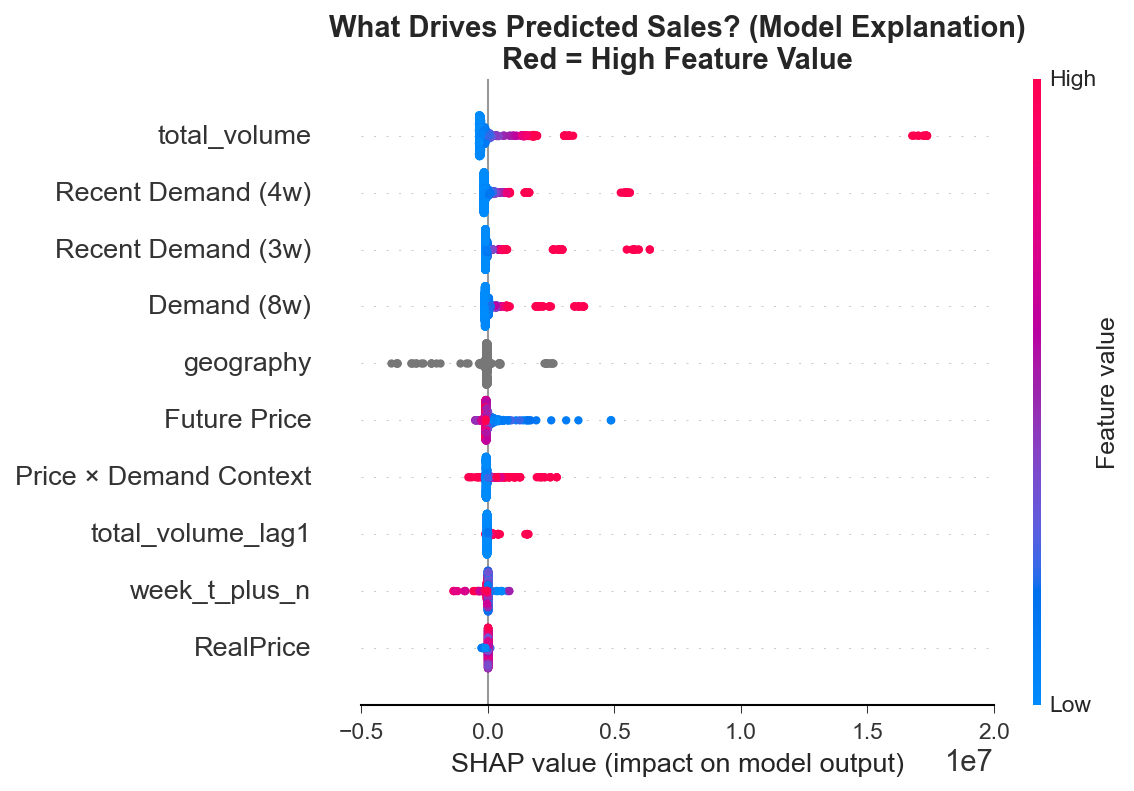

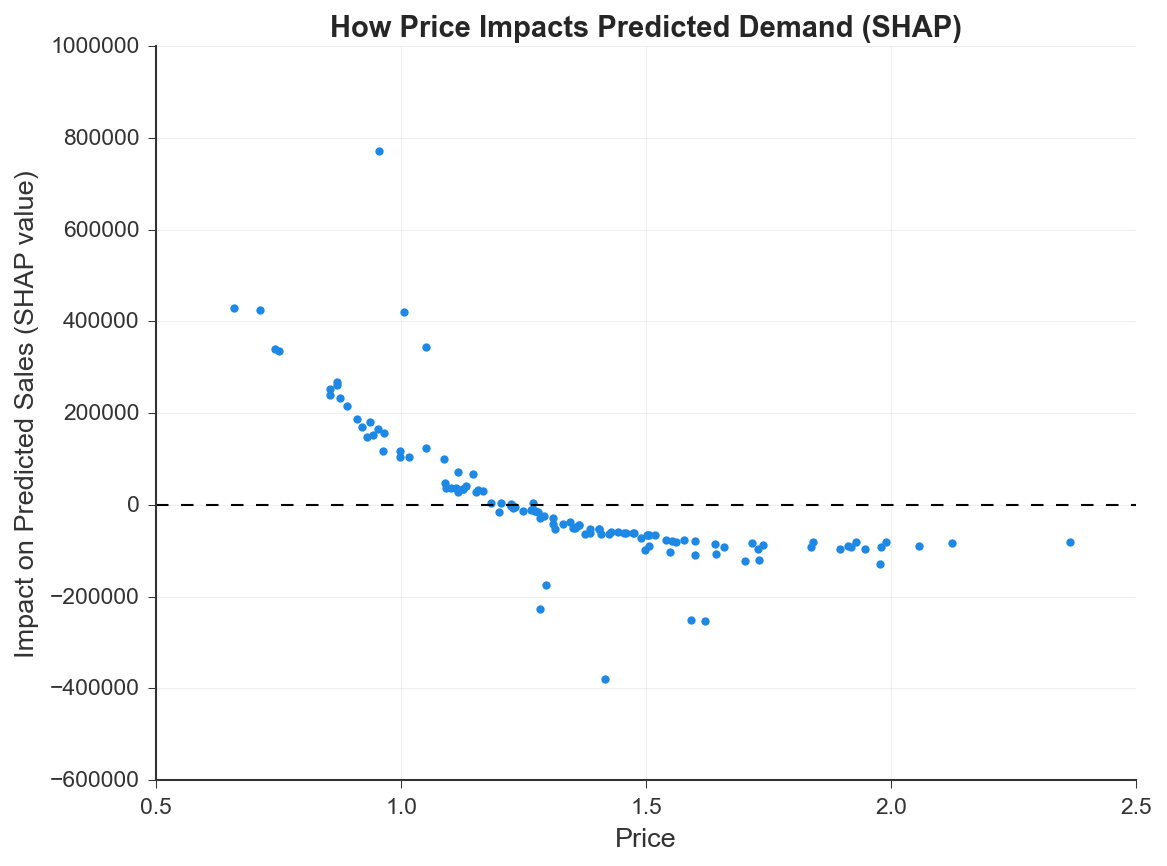

In [15]:
# Load trained XGBoost model
loaded_model = joblib.load("xgb_all.joblib")

# Use a sample for speed and clarity in demos
X_sample = X_test.sample(1000, random_state=42)
feature_map = {
    "RealPrice_t_plus_n": "Future Price",
    "total_volume_rollmedian4": "Recent Demand (4w)",
    "total_volume_rollmedian3": "Recent Demand (3w)",
    "total_volume_rollmedian8": "Demand (8w)",
    "price_volume_interaction": "Price × Demand Context",
}

X_sample_renamed = X_sample.rename(columns=feature_map)
# Initialize SHAP TreeExplainer
explainer = shap.TreeExplainer(loaded_model)

# Compute SHAP values
# SHAP explains how the *model* arrives at its predictions
shap_values = explainer(
    X_sample_renamed,
    check_additivity=False
)

# --------------------------------------------------
# Global Interpretability: What drives predictions?
# --------------------------------------------------

plt.figure(figsize=(8, 6))
plt.title(
    "What Drives Predicted Sales? (Model Explanation)\n"
    "Red = High Feature Value",
    fontsize=14,
    fontweight="bold"
)

shap.summary_plot(
    shap_values,
    X_sample_renamed,
    max_display=10,
    show=False
)

plt.tight_layout()
plt.show()

# --------------------------------------------------
# Price Interpretability: How price impacts demand
# --------------------------------------------------
plt.figure(figsize=(8, 6))
ax = plt.gca()

shap.dependence_plot(
    "RealPrice_t_plus_n",        
    shap_values.values[:120],         
    X_sample[:120],
    interaction_index=None,   
    ax=ax,
    show=False
)
# Reference line for positive vs negative impact
ax.axhline(0, color="black", linestyle="--", linewidth=1)

ax.set_title(
    "How Price Impacts Predicted Demand (SHAP)",
    fontsize=14,
    fontweight="bold"
)
ax.set_xlabel("Price")
ax.set_ylabel("Impact on Predicted Sales (SHAP value)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Optimal Price Simulation
For each point, we:
1. Simulate dozens of price multipliers  
2. Filter price points within historical safe ranges
3. Predict sales volume 
4. Compute revenue = price * predicted volume
5. Select the price that maximizes revenue

interactive(children=(Dropdown(description='City:', index=8, options=('Albany', 'Atlanta', 'Baltimore/Washingt…

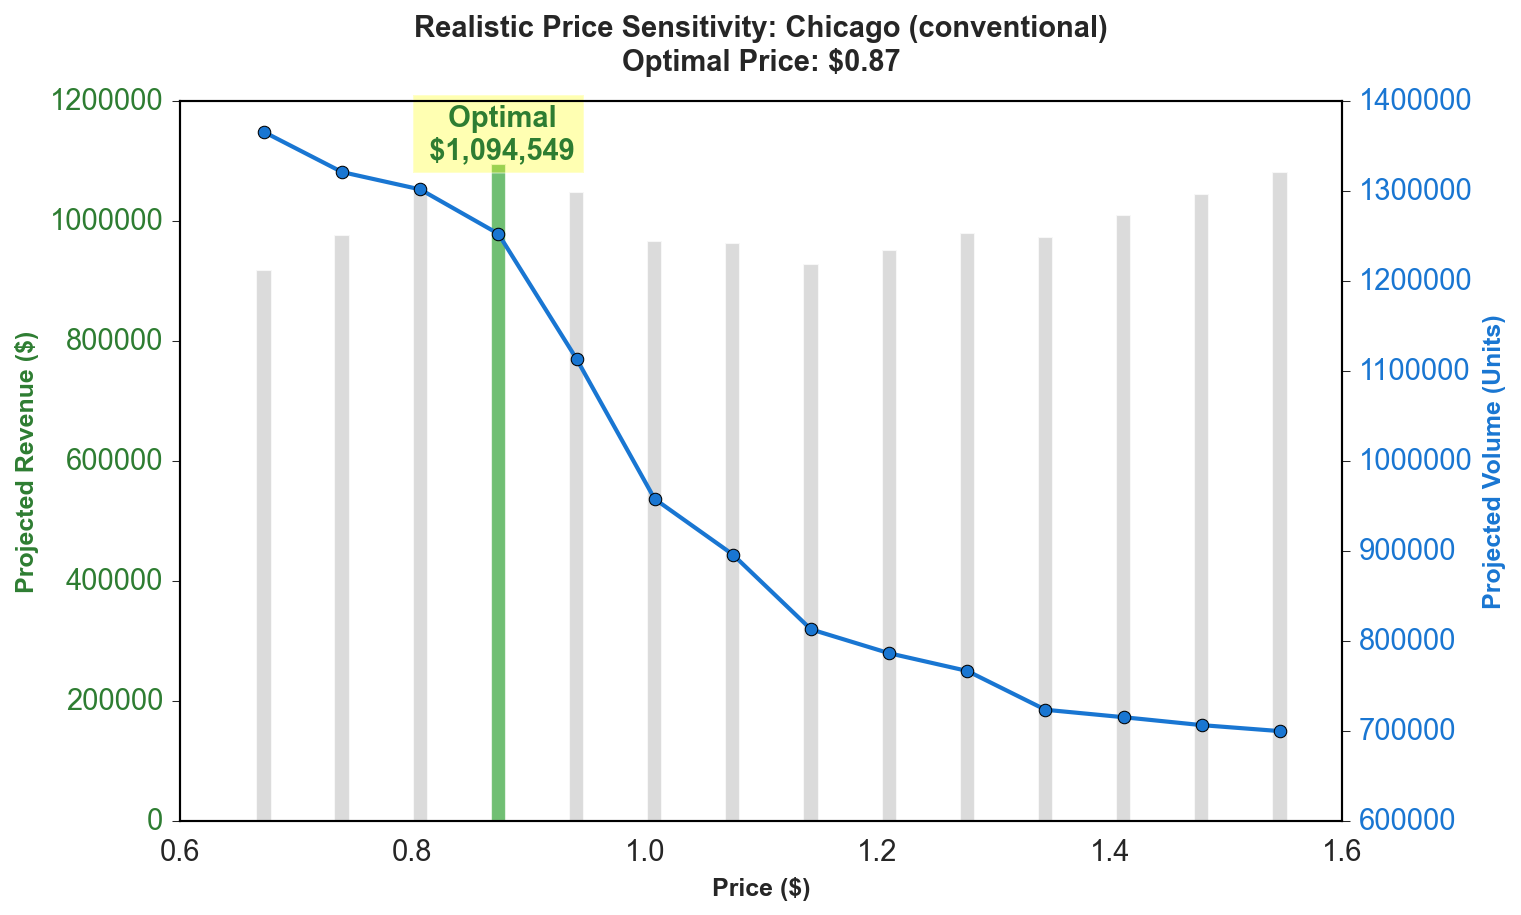

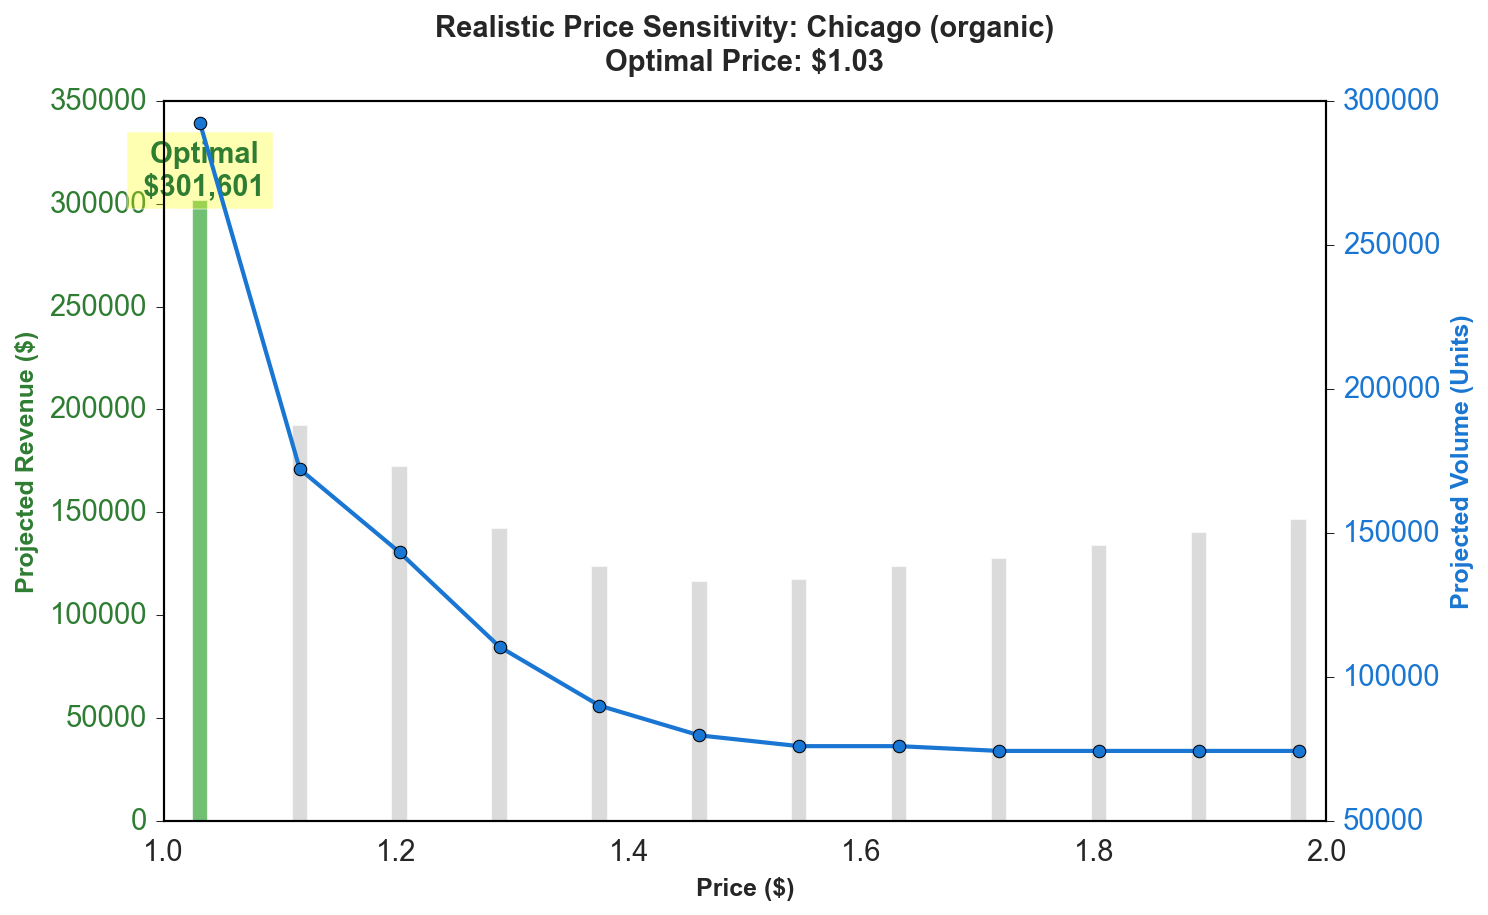

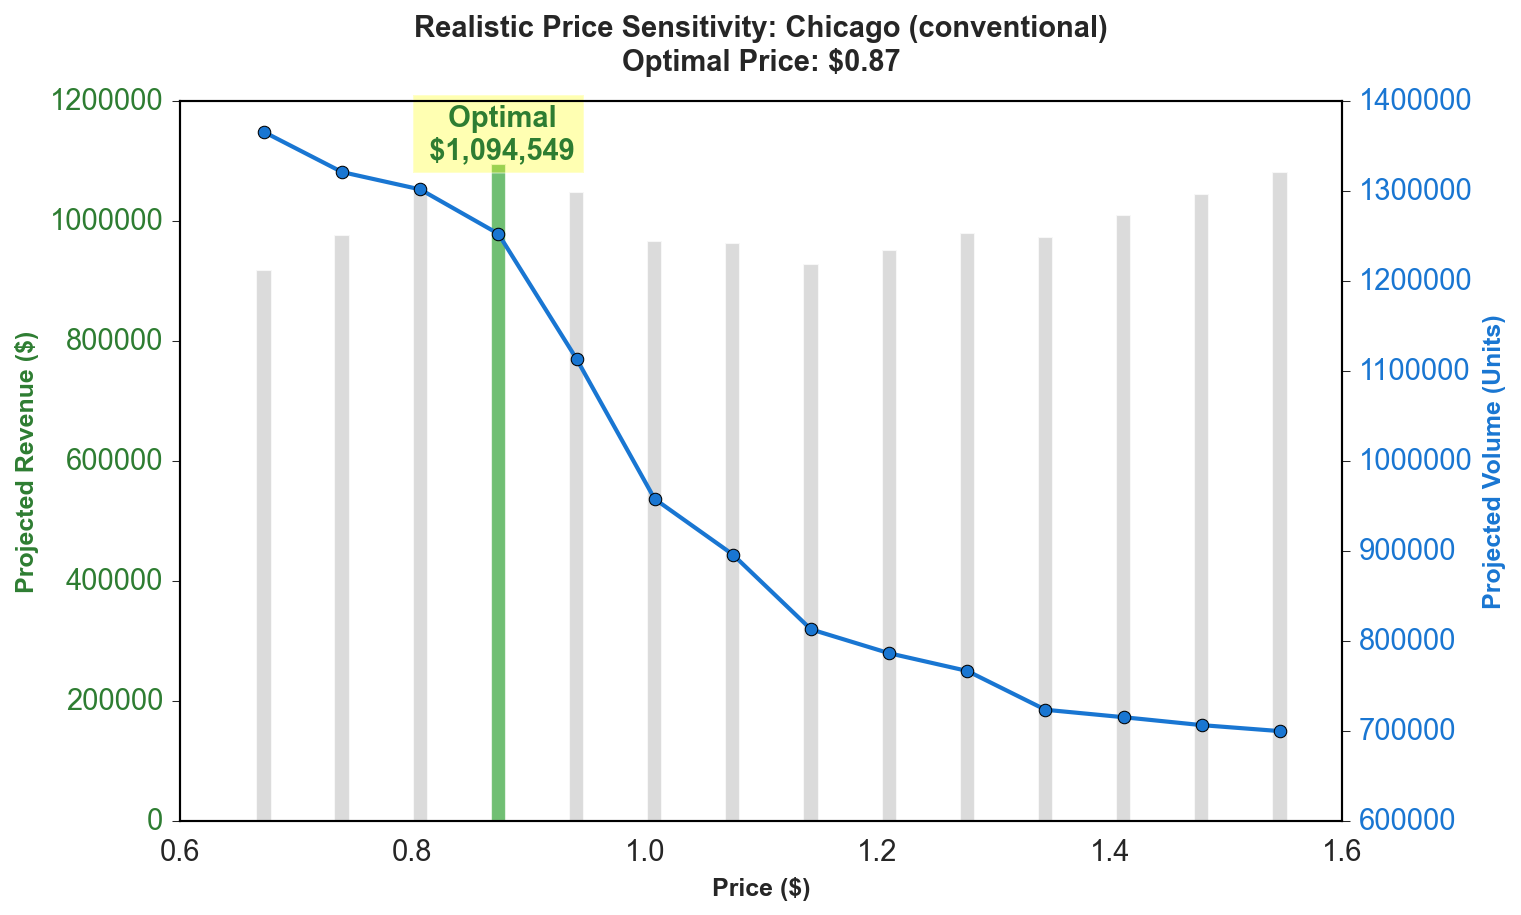

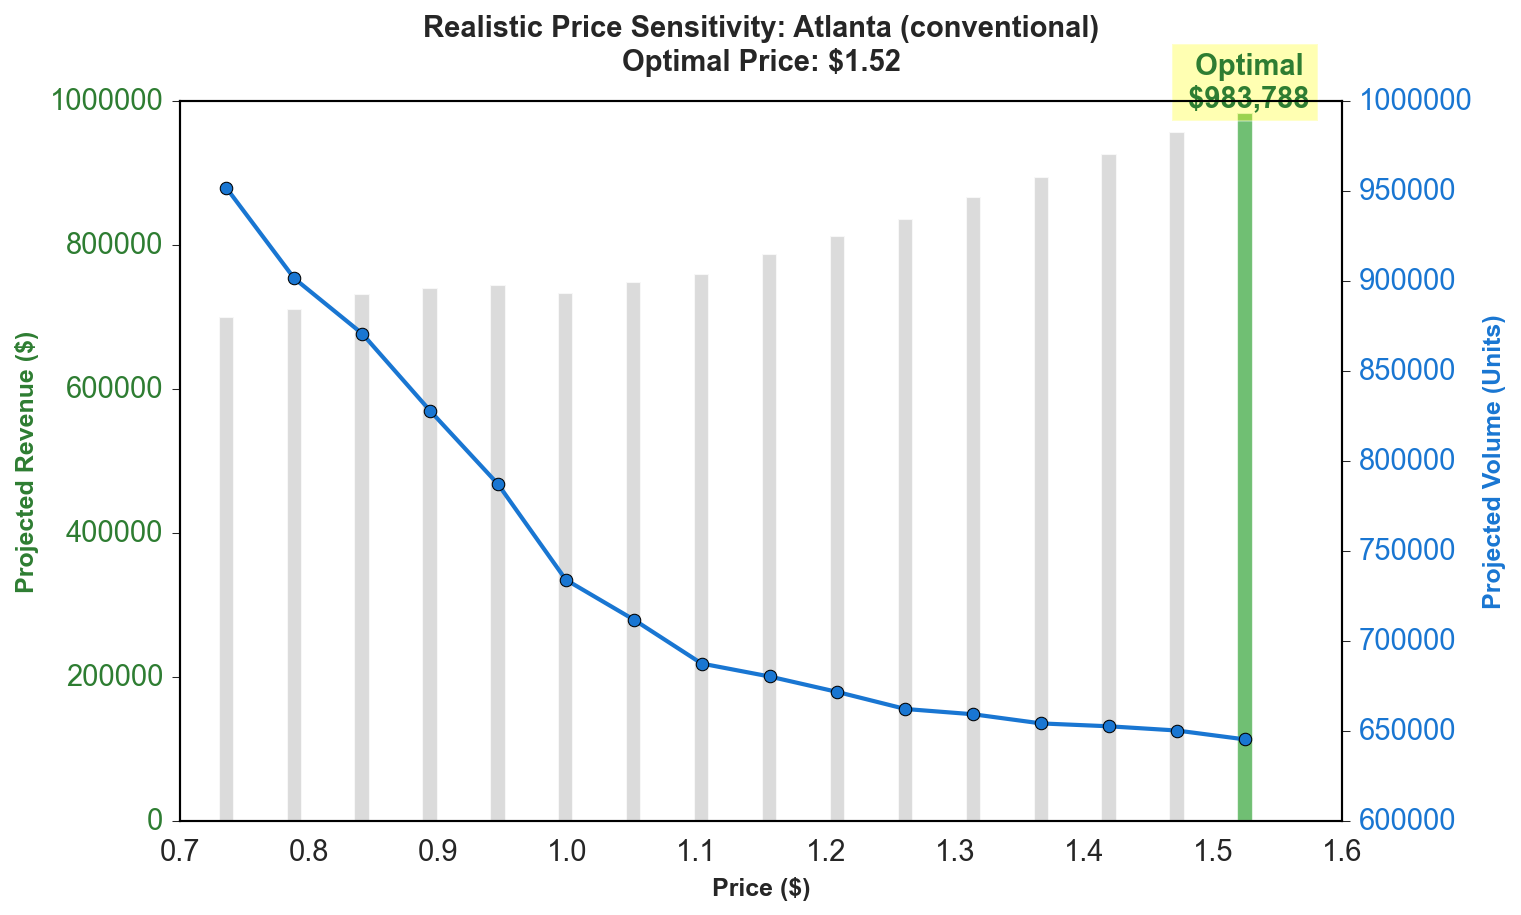

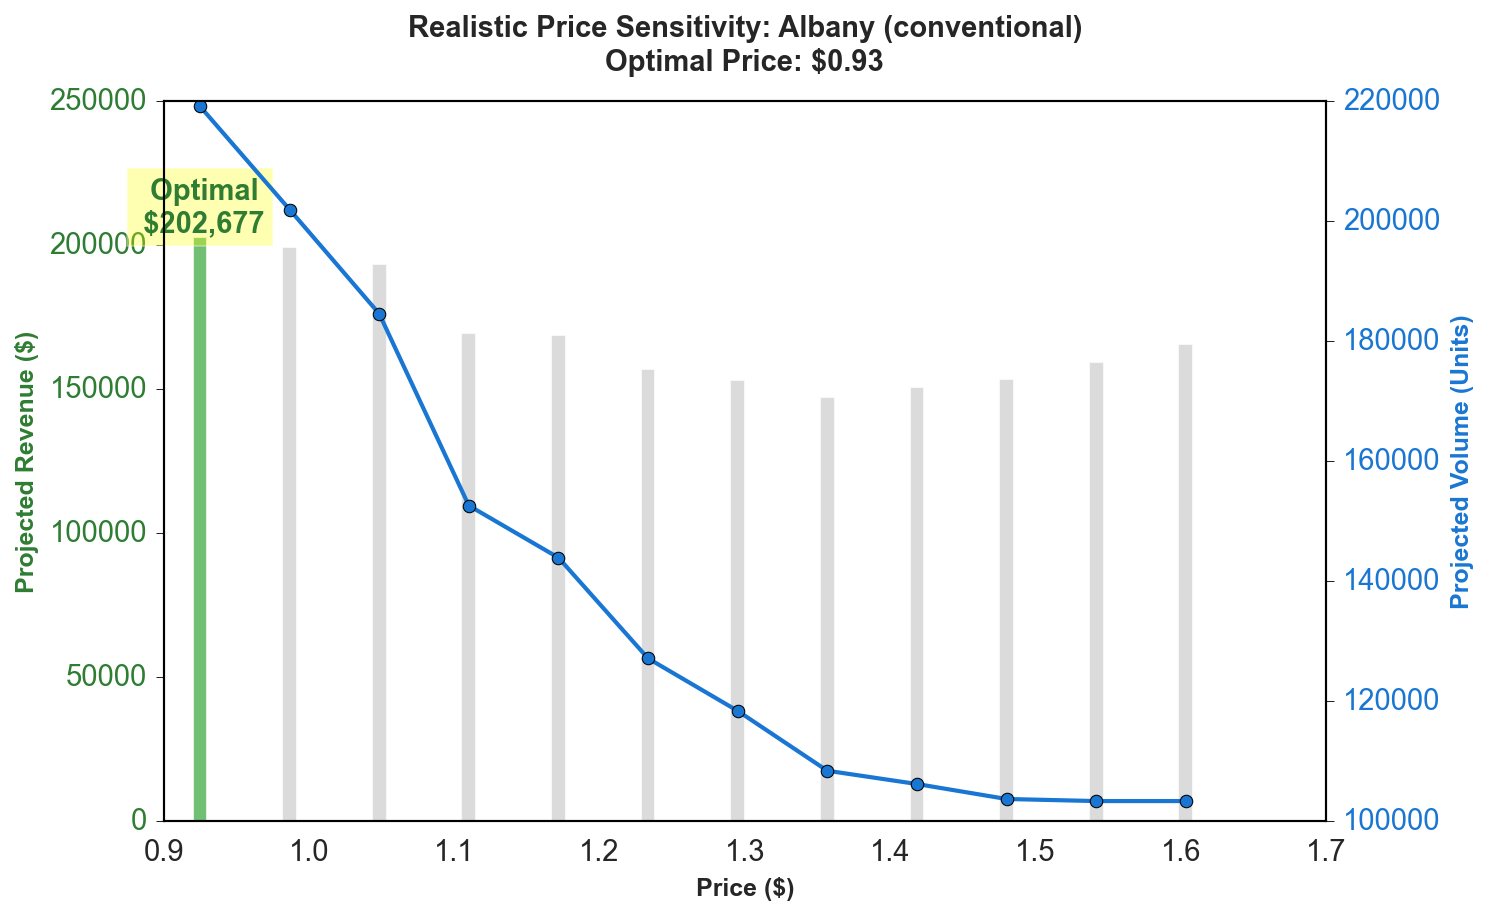

In [16]:
def plot_realistic_price_sensitivity(city, avocado_type, data, X_data, model):
    """
    Plot price sensitivity strictly within historical price bounds to avoid model extrapolation.

    Generates projected sales volume and revenue for realistic price scenarios for a specific
    city and avocado type. Highlights the optimal price (max revenue) and plots both revenue and 
    volume against price.

    Parameters
    city : str
        City/geography for the analysis.
    avocado_type : str
        Avocado type ('conventional' or 'organic').
    data : pd.DataFrame
        Original dataset containing historical price and target information.
    X_data : pd.DataFrame
        Feature dataset used for predictions, must include the price column.
    model : object
        Trained model with a `predict` method accepting X_data format.

    Returns
    None
        Displays an interactive plot and prints recommended optimal price and expected revenue gain.
    """
    clear_output(wait=True)
    # Filter Data for specific City/Type
    mask = (X_data['geography'] == city) & (X_data['type'] == avocado_type)
    subset = X_data[mask]

    if len(subset) == 0:
        # Clear any previous plot and display error message
        plt.close('all')
        print(f"Error: No data found for {city} - {avocado_type}")
        return

    # Establish Historical "Safe Zone" and Baseline
    price_col = 'RealPrice_t_plus_n' if 'RealPrice_t_plus_n' in subset.columns else 'AveragePrice'
    
    # Check if the price column exists in the subset
    if price_col not in subset.columns:
        plt.close('all')
        print(f"Error: Required price column '{price_col}' not found.")
        return
    # Get price range from dataset and not test data
    masked_data = (data['geography'] == city) & (data['type'] == avocado_type)
    subset_data = data[masked_data]
    min_safe_price = subset_data[price_col].min()
    max_safe_price = subset_data[price_col].max()
    
    # Baseline (using most recent/first row as reference)
    base_row = subset.iloc[50:51]
    original_price = base_row[price_col].values[0]

    # Display status
    print(f"--- Running Analysis for {city} ({avocado_type}) ---")
    print(f"Baseline Price:   ${original_price:.2f}")
    print(f"Safe Price Range: ${min_safe_price:.2f} to ${max_safe_price:.2f} (Historical Data)")

    raw_multipliers = np.arange(0.5, 2, 0.05)
    results = []

    for m in raw_multipliers:
        sim_price = original_price * m
        
        # Only proceed within historical bounds ---
        if min_safe_price <= sim_price <= max_safe_price:
            
            # Run Prediction
            sim_row = base_row
            sim_row[price_col] = sim_price
            try:
                predicted_value = model.predict(sim_row)
                pred_volume = predicted_value[0]
            except Exception as e:
                # Handle model error if necessary
                print(f"Model prediction failed: {e}")
                continue 
            
            results.append({
                'multiplier': m,
                'pct_change': (m - 1) * 100,
                'sim_price': sim_price,
                'pred_volume': pred_volume,
                'pred_revenue': pred_volume * sim_price 
            })

    if not results:
        plt.close('all')
        print("Warning: Simulation range is too narrow or original price is out of bounds.")
        return

    df_results = pd.DataFrame(results)
    
    
    # For better visualisation 
    vols = df_results['pred_volume'].values

    flat_start = None
    tol = 1e-6  # tolerance for "flat"

    for i in range(1, len(vols)):
        if abs(vols[i] - vols[i-1]) < tol:
            flat_start = i
            break

    # Minimum points to keep to avoid over-trimming
    MIN_POINTS = 12

    if flat_start is not None:
        # Ensure we keep at least MIN_POINTS
        keep_until = max(flat_start, MIN_POINTS)

        # print(f"⚠ Flat-line detected at index {flat_start}. Keeping first {keep_until} points.")
        df_results = df_results.iloc[:keep_until]

    # Find Optima within Safe Zone
    baseline_idx = (df_results['pct_change']).abs().idxmin()
    baseline_rev = df_results.loc[baseline_idx, 'pred_revenue']
    baseline_sales = df_results.loc[baseline_idx, 'pred_volume']
    optimal_idx = df_results['pred_revenue'].idxmax()
    optimal_price = df_results.loc[optimal_idx, 'sim_price']
    optimal_rev = df_results.loc[optimal_idx, 'pred_revenue']
    optimal_pct = df_results.loc[optimal_idx, 'pct_change']
    optimal_sales = df_results.loc[optimal_idx, 'pred_volume']

    # Visualization
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Revenue Bar Chart (absolute price on x-axis)
    colors = ['#4CAF50' if x == optimal_price else '#d3d3d3' for x in df_results['sim_price']]
    bars = ax1.bar(
        df_results['sim_price'],
        df_results['pred_revenue'],
        width=(df_results['sim_price'].max() - df_results['sim_price'].min()) * 0.015,
        color=colors,
        alpha=0.8
    )

    ax1.set_xlabel('Price ($)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Projected Revenue ($)', fontsize=12, fontweight='bold', color='#2E7D32')
    ax1.tick_params(axis='y', labelcolor='#2E7D32')

    # Volume line chart (absolute price on x-axis)
    ax2 = ax1.twinx()
    ax2.plot(df_results['sim_price'], df_results['pred_volume'],
            color='#1976D2', marker='o', linewidth=2)
    ax2.set_ylabel('Projected Volume (Units)', fontsize=12, fontweight='bold', color='#1976D2')
    ax2.tick_params(axis='y', labelcolor='#1976D2')

    # Title
    plt.title(
        f"Realistic Price Sensitivity: {city} ({avocado_type})\nOptimal Price: ${optimal_price:.2f}",
        fontsize=14, fontweight='bold', pad=15
    )

    # Optimal point annotation
    ax1.text(
        optimal_price, optimal_rev,
        f" Optimal\n ${optimal_rev:,.0f}",
        ha='center', va='bottom',
        fontweight='bold', color='#2E7D32',
        bbox=dict(facecolor='yellow', alpha=0.3)
    )
    
    # Print final recommendation
    print(f"\nRecommendation: Adjust price to ${optimal_price:.2f} (by {optimal_pct:+.1f}% )")
    print(f"Revenue Gain vs. Baseline: ${(optimal_rev - baseline_rev):+,.2f}")
    

# ======================================================================
# INTERACTIVE WIDGET IMPLEMENTATION
# ======================================================================

def setup_interactive_plot(data, X_data, loaded_model):
    """Sets up the dropdown widgets and connects them to the plotting function."""
    
    # Determine unique options from the dataset
    available_cities = sorted(X_data['geography'].unique())
    available_types = ['conventional', 'organic'] # fixed
    
    # Define the Dropdown widgets
    city_dropdown = Dropdown(
        options=available_cities,
        value="Chicago", # Set default value
        description='City:',
    )

    type_dropdown = Dropdown(
        options=available_types,
        value="conventional",
        description='Type:',
    )
    
    # Link the widgets to the plotting function
    # 'interact' automatically calls the function whenever a widget changes.
    # We use 'fixed' for the DataFrame and Model as they don't change.
    interact(
        plot_realistic_price_sensitivity,
        city=city_dropdown,
        avocado_type=type_dropdown,
        data = fixed(data),
        X_data=fixed(X_data), 
        model=fixed(loaded_model)
    )


try:
    setup_interactive_plot(df_model, X_test, loaded_model)
except NameError:
    print("ERROR: Please ensure 'X_test' (DataFrame) and 'loaded_model' are defined before running 'setup_interactive_plot'.")